# 1. Imports & Setup

In [270]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import random, os, csv, datetime, uuid, time, itertools

from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# For Reproducibility
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

%matplotlib inline

# 2. Load & Sort Data

In [229]:
ticker = "AAPL"
df = pd.read_csv(f'..\..\data\processed\{ticker}_processed_data_full.csv', parse_dates=['Date'])
df = df.sort_values(by='Date').reset_index(drop=True)

# 3. Feature Engineering

## One-Day Return
- Is simply the percentage change in price from one day to the next
- Helps pick up on the rate of change in the market rather than raw price levels
- Scale‐invariance: Returns normalize price changes into a small, stable range so the model isn’t thrown off by the stock’s overall price drift.
- Momentum & mean‐reversion: Returns capture serial correlation, helping the network spot short‐lived trends and reversals.
- Stationarity: Returns have steadier statistics over time than raw prices, which makes neural‐net training more stable.

In [230]:
df['Return'] = df['Close'].pct_change()
df = df.dropna(subset=['Return'])   # drop first row

## 10-day Exponential Moving Average (EMA-10)
- Emphasizes recent moves: unlike a simple moving average, an EMA gives exponentially more weight to the latest days, so it reacts faster to new trends.
- Filters noise: it smooths out day-to-day volatility so your model can see the underlying short-term trend more clearly.
- Captures momentum: crossing patterns (e.g. price above vs. below its EMA) are classic signals for up- or down-momentum.

In [239]:
df["EMA10"] = df["Close"].ewm(span=10, adjust=False).mean()

# Drop the initial NaNs from the EMA calculation
df = df.dropna(subset=["EMA10"]).reset_index(drop=True)

## 20-Day Rolling Volatility
Gives DNN “a sense” of how choppy the market has been. When volatility is high, your model will know to expect bigger swings and adjust its predictions (helping correct that over-prediction bias).

In [240]:
WINDOW_VOL = 20
df['Volatility20'] = df['Return'].rolling(window=WINDOW_VOL).std()

# Drop the initial rows that have NaN volatility  
df = df.dropna(subset=['Volatility20']).reset_index(drop=True)

## 20-Day Exponential Moving Average (EMA20)
- Exponential Moving Average over 20 days (slower trend)
- Gives a medium‐term trend line—smoother than raw price but more responsive than a 50-day MA—helping the model see emerging up- or down-trends.
- augments your EMA10 with a broader view of trend.

In [241]:
df['EMA20'] = df['Close'].ewm(span=20, adjust=False).mean()
df = df.dropna(subset=["EMA20"]).reset_index(drop=True)

## 14-day Relative Strength Index (RSI14)
- Relative Strength Index over 14 days
- Captures over-bought (>70) or over-sold (<30) conditions—i.e. momentum extremes—which often precede short-term reversals
- flags extreme momentum turns that raw returns might miss.

In [242]:
delta      = df['Close'].diff()
up, down   = delta.clip(lower=0), -delta.clip(upper=0)
roll_up    = up.ewm(span=14, adjust=False).mean()
roll_down  = down.ewm(span=14, adjust=False).mean()
rs         = roll_up / roll_down
df['RSI14'] = 100 - (100 / (1 + rs))

df = df.dropna(subset=["RSI14"]).reset_index(drop=True)

## Moving Average Convergence/Divergence (MACD)
-  Highlights shifts in momentum by comparing fast vs. slow trends; a rising MACD means short-term strength is outpacing the longer trend
- capture both the magnitude and timing of momentum shifts.

In [235]:
ema12 = df['Close'].ewm(span=12, adjust=False).mean()
ema26 = df['Close'].ewm(span=26, adjust=False).mean()
df['MACD'] = ema12 - ema26
df['MACD_signal'] = df['MACD'].ewm(span=9, adjust=False).mean()

df = df.dropna(subset=['MACD','MACD_signal']).reset_index(drop=True)

# 4. Train/Validation/Test Split (60 / 20 / 20)

In [ ]:
n       = len(df)
i_train = int(0.6  * n)    # first 60% → train
i_val   = int(0.8  * n)    # next 20% → val
# last 20% → test

train_df = df.iloc[:i_train].copy()
val_df   = df.iloc[i_train:i_val].copy()
test_df  = df.iloc[i_val:].copy()


# 5. Define Features and Target

In [244]:
feature_cols = [ # can be modified
    'Close',
    'Return',
    'Volume',
    'EMA10',        
    'Volatility20',
    'EMA20',
    'RSI14',
    'MACD',
    'MACD_signal'
] 

target_col = "Target"

# 6. Define Scaling Function and Windows Function

In [277]:
# Prep function (scaling)
x_scaler = StandardScaler().fit(train_df[feature_cols])
y_scaler = StandardScaler().fit(train_df[['Target']])   # fit on raw price

def prep(df):
    X = x_scaler.transform(df[feature_cols])
    y = df[target_col].values # original
    # y = y_scaler.transform(df[['Target']]).flatten() # scaling y
    return X, y

# Sliding-window function
def make_windows(X, y, W):
    Xs, ys = [], []
    for i in range(W, len(X)):
        Xs.append(X[i-W:i].flatten())
        ys.append(y[i])
    return np.array(Xs), np.array(ys)

# 7. Scale and Make Windows (Single Run Experiment Only)

In [252]:
window_size = 20  # your chosen look-back
X_tr_full, y_tr = prep(train_df)
X_va_full, y_va = prep(val_df)
X_te_full, y_te = prep(test_df)

X_train, y_train = make_windows(X_tr_full, y_tr, window_size)
X_val,   y_val   = make_windows(X_va_full, y_va, window_size)
X_test,  y_test  = make_windows(X_te_full, y_te, window_size)

# 8. DNN Model Builder Function

In [247]:
def build_dnn(window_size,
              num_features,
              layer1_units,
              layer2_units,
              dropout_rate,
              learning_rate):
    """
    Builds & compiles a 2-layer DNN with BatchNorm + Dropout.
    """
    model = Sequential([
        Dense(layer1_units, activation='relu',
              input_shape=(window_size * num_features,)),
        BatchNormalization(),
        Dense(layer2_units, activation='relu'),
        Dropout(dropout_rate),
        Dense(1)
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate),
        loss='mse',
        metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')]
    )
    return model


# 9. Single-Run Training (Single Run Experiment Only)

In [253]:
# Parameters for your “final” Level-4 run
description = "Using results from hyperparameter search" # for logging

num_features = len(feature_cols) # number of features
layer_1_units = 128 # layer 1 units
layer_2_units = 128 # layer 2 units
dropout = 0.2 # dropout rate
learning_rate_num = 1e-3 # learning rate
batch_size_input = 32

model = build_dnn(window_size, num_features, layer_1_units, layer_2_units,
                  dropout, learning_rate_num)

# Train w/ Early Stopping
es = EarlyStopping(monitor='val_rmse', patience=5, restore_best_weights=True)

start_time = time.time()  # start time to log training time

# Train Model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=batch_size_input,
    callbacks=[es],
    verbose=2
)

train_time = round(time.time() - start_time, 2) # stop time, for logging

model.summary()

# log variables
num_params = model.count_params() # for logging
epochs_run = len(history.history["loss"]) # for logging 
val_rmse   = history.history["val_rmse"][-1] # for logging
train_rmse = history.history["rmse"][-1] # for logging

# test on test set and display RMSEs
test_loss, test_rmse = model.evaluate(X_test, y_test, verbose=0) # for logging
print(f"Train RMSE: {train_rmse:.4f}")
print(f"Val RMSE: {val_rmse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")


Epoch 1/100


c:\Users\diana\Documents\Current Classes\Artificial Intelligence - COSC 4368\Course Project\stock-market-prediction-project\venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


37/37 - 1s - 28ms/step - loss: 5170.3823 - rmse: 71.9054 - val_loss: 6049.6919 - val_rmse: 77.7798
Epoch 2/100
37/37 - 0s - 3ms/step - loss: 1939.8442 - rmse: 44.0437 - val_loss: 1507.3315 - val_rmse: 38.8244
Epoch 3/100
37/37 - 0s - 3ms/step - loss: 657.1337 - rmse: 25.6346 - val_loss: 89.5636 - val_rmse: 9.4638
Epoch 4/100
37/37 - 0s - 3ms/step - loss: 444.5403 - rmse: 21.0841 - val_loss: 86.3945 - val_rmse: 9.2949
Epoch 5/100
37/37 - 0s - 3ms/step - loss: 358.2562 - rmse: 18.9277 - val_loss: 68.6866 - val_rmse: 8.2877
Epoch 6/100
37/37 - 0s - 3ms/step - loss: 292.8026 - rmse: 17.1115 - val_loss: 79.7675 - val_rmse: 8.9313
Epoch 7/100
37/37 - 0s - 3ms/step - loss: 253.1740 - rmse: 15.9114 - val_loss: 97.6125 - val_rmse: 9.8799
Epoch 8/100
37/37 - 0s - 3ms/step - loss: 220.2214 - rmse: 14.8399 - val_loss: 53.4178 - val_rmse: 7.3087
Epoch 9/100
37/37 - 0s - 3ms/step - loss: 210.3196 - rmse: 14.5024 - val_loss: 118.2841 - val_rmse: 10.8758
Epoch 10/100
37/37 - 0s - 3ms/step - loss: 208.

Model: "sequential_146"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_428 (Dense)               │ (None, 128)            │        23,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_136         │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_429 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_136 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_430 (Dense)               │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 120,453 (470.52 KB)

 Trainable params: 40,065 (156.50 KB)

 Non-trainable params: 256 (1.00 KB)

 Optimizer params: 80,132 (313.02 KB)

Train RMSE: 12.8985
Val RMSE: 8.9621
Test RMSE: 13.9730


# 10. Hyperparameter Search

In [278]:
# 1) Define your grid
param_grid = {
    'window_size':   [20, 30],
    'learning_rate': [1e-3, 1e-4],
    'batch_size':    [32, 64],
    'layer1_units':  [128, 256],
    'layer2_units':  [64, 128],
    'dropout_rate':  [0.2, 0.3]
}
hp_results = []

# 2) Loop through combinations
for ws, lr, bs, l1, l2, dr in itertools.product(*param_grid.values()):
     # a) Scale & window using helpers
    X_tr_raw, y_tr = prep(train_df)
    X_va_raw, y_va = prep(val_df)
    X_train, y_train = make_windows(X_tr_raw, y_tr, ws)
    X_val,   y_val   = make_windows(X_va_raw, y_va, ws)

    # b) Build & compile
    m = build_dnn(ws, len(feature_cols), l1, l2, dr, lr)

    # c) Train
    es = EarlyStopping('val_rmse', patience=5, restore_best_weights=True)
    t0 = time.time()

    # Train Model
    h  = m.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=100, batch_size=bs,
        callbacks=[es], verbose=0
    )
    dt = time.time() - t0

    best_val_rmse = min(h.history['val_rmse'])
    best_epoch    = h.history['val_rmse'].index(best_val_rmse)
    best_train_rmse = h.history['rmse'][best_epoch]

    # d) Record
    hp_results.append({
        'window_size': ws, 'learning_rate': lr,
        'batch_size': bs, 'layer1_units': l1,
        'layer2_units': l2, 'dropout_rate': dr,
        'train_rmse': best_train_rmse,
        'val_rmse': best_val_rmse,
        'epochs_run': len(h.history['loss']),
        'train_time_s': round(dt,2)
    })

# 3) Summarize
df_hp = pd.DataFrame(hp_results).sort_values('val_rmse').reset_index(drop=True)
display(df_hp.head(10))

c:\Users\diana\Documents\Current Classes\Artificial Intelligence - COSC 4368\Course Project\stock-market-prediction-project\venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\diana\Documents\Current Classes\Artificial Intelligence - COSC 4368\Course Project\stock-market-prediction-project\venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\diana\Documents\Current Classes\Artificial Intelligence - COSC 4368\Course Project\stock-market-prediction-project\

,window_size,learning_rate,batch_size,layer1_units,layer2_units,dropout_rate,train_rmse,val_rmse,epochs_run,train_time_s
0,20,0.0010,32,256,128,0.2,12.575130,6.022925,18,3.39
1,20,0.0010,32,128,128,0.3,13.530312,6.045497,17,3.27
2,20,0.0010,32,256,128,0.3,14.015655,6.359599,17,3.23
3,20,0.0010,64,256,128,0.2,11.238253,6.504826,19,3.03
4,20,0.0010,32,256,64,0.3,17.382404,6.555009,13,2.90
5,20,0.0010,32,128,128,0.2,11.418344,6.840313,22,4.12
6,20,0.0010,32,256,64,0.2,15.795893,6.950110,17,3.17
7,30,0.0001,64,256,128,0.3,21.504232,7.026240,38,4.78
8,20,0.0010,64,256,128,0.3,14.354408,7.177084,14,2.35
9,20,0.0001,64,256,128,0.3,23.017975,7.250150,41,5.39


# 11. Build Model w/ Best Inputs from Hyperparameter Search

In [ ]:
# 1) Grab the best hyperparams
best = df_hp.iloc[0]

best_window_size = int(best.window_size) 
best_batch_size = int(best.batch_size)

# 2) Re-window using the same W
X_tr_full, y_tr = prep(train_df)
X_va_full, y_va = prep(val_df)
X_te_full, y_te = prep(test_df)

X_train, y_train = make_windows(X_tr_full, y_tr, best_window_size)
X_val,   y_val   = make_windows(X_va_full, y_va, best_window_size)
X_test,  y_test  = make_windows(X_te_full, y_te, best_window_size)

# 3) Build the model with the best layers & lr
n_features = len(feature_cols)
best_model = build_dnn(
    best_window_size,           # window_size
    len(feature_cols),          # num_features
    int(best.layer1_units),     # layer1_units
    int(best.layer2_units),     # layer2_units
    best.dropout_rate,          # dropout_rate
    best.learning_rate          # learning_rate
)

# 4) Train with the best batch size & early stopping
es = EarlyStopping(monitor='val_rmse', patience=5, restore_best_weights=True)
best_history = best_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=best_batch_size,
    callbacks=[es],
    verbose=2
)

# 5) Evaluate and pull out best‐epoch RMSEs
best_epoch = best_history.history['val_rmse'].index(min(best_history.history['val_rmse']))
train_rmse = best_history.history['rmse'][best_epoch]
val_rmse   = min(best_history.history['val_rmse'])

# 6) Evaluate on test
test_loss, test_rmse = best_model.evaluate(X_test, y_test, verbose=0)

# 7) Make predictions on the test target
y_pred = best_model.predict(X_test).flatten()

# 8) Extra metrics
test_mae = mean_absolute_error(y_test, y_pred)
test_r2  = r2_score(y_test, y_pred)


Epoch 1/100


c:\Users\diana\Documents\Current Classes\Artificial Intelligence - COSC 4368\Course Project\stock-market-prediction-project\venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


37/37 - 1s - 29ms/step - loss: 4540.7930 - rmse: 67.3854 - val_loss: 2227.9832 - val_rmse: 47.2015
Epoch 2/100
37/37 - 0s - 4ms/step - loss: 993.7665 - rmse: 31.5241 - val_loss: 98.8486 - val_rmse: 9.9423
Epoch 3/100
37/37 - 0s - 3ms/step - loss: 491.9544 - rmse: 22.1800 - val_loss: 511.8913 - val_rmse: 22.6250
Epoch 4/100
37/37 - 0s - 4ms/step - loss: 412.7663 - rmse: 20.3167 - val_loss: 290.5952 - val_rmse: 17.0469
Epoch 5/100
37/37 - 0s - 3ms/step - loss: 321.9530 - rmse: 17.9431 - val_loss: 206.8642 - val_rmse: 14.3828
Epoch 6/100
37/37 - 0s - 3ms/step - loss: 263.7763 - rmse: 16.2412 - val_loss: 119.3322 - val_rmse: 10.9239
Epoch 7/100
37/37 - 0s - 3ms/step - loss: 218.8510 - rmse: 14.7936 - val_loss: 54.6995 - val_rmse: 7.3959
Epoch 8/100
37/37 - 0s - 3ms/step - loss: 204.1101 - rmse: 14.2867 - val_loss: 39.0558 - val_rmse: 6.2495
Epoch 9/100
37/37 - 0s - 3ms/step - loss: 198.0234 - rmse: 14.0721 - val_loss: 62.1978 - val_rmse: 7.8866
Epoch 10/100
37/37 - 0s - 3ms/step - loss: 19

# Output Results from Best Model

Train RMSE @ best epoch: 14.2867
Val   RMSE @ best epoch: 6.2495
Test  RMSE:              5.7462
Test  MAE:               4.4774
Test  R²:                0.9444


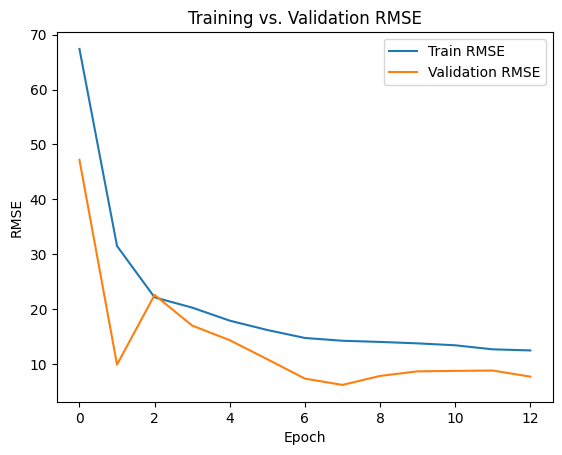

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


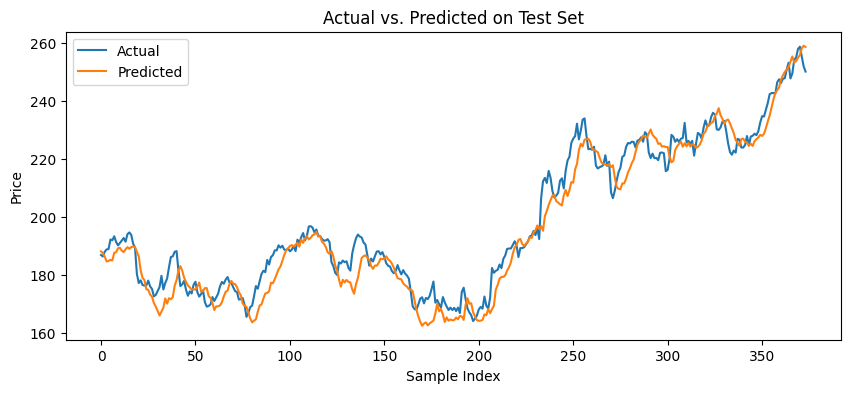

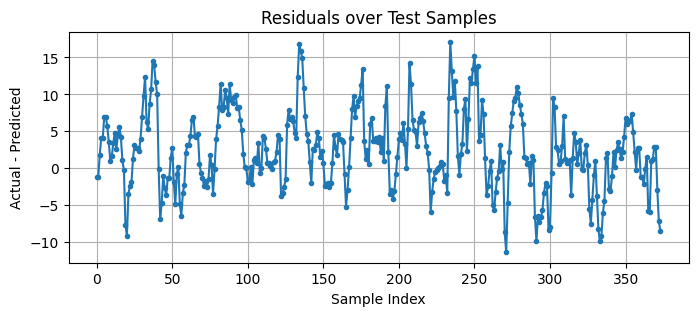

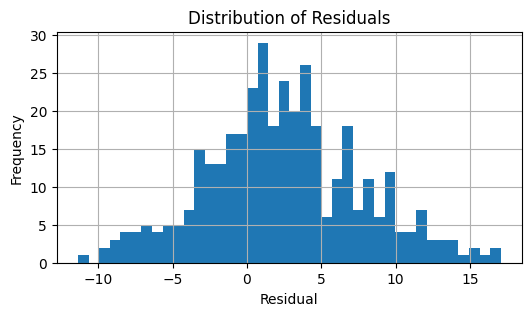

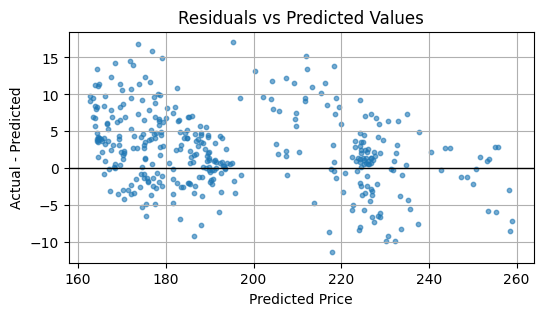

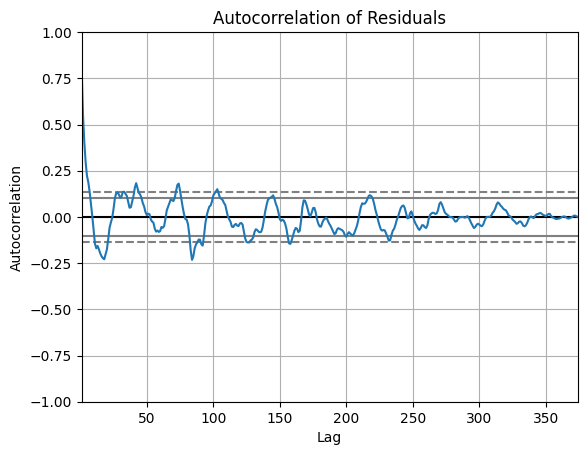

In [ ]:
print(f"Train RMSE @ best epoch: {train_rmse:.4f}")
print(f"Val   RMSE @ best epoch: {val_rmse:.4f}")
print(f"Test  RMSE:              {test_rmse:.4f}")
print(f"Test  MAE:               {test_mae:.4f}")
print(f"Test  R²:                {test_r2:.4f}")

plot_diagnostics(best_history, best_model, X_test, y_test)

# Log Best Model Experiment

In [291]:
num_params  = best_model.count_params()
epochs_run  = len(best_history.history['loss'])
layers      = (int(best.layer1_units), int(best.layer2_units))

log_experiment(
    ticker         = ticker,                   # e.g. "AAPL"
    description    = "Level-5 DNN (best hyperparams)",
    window_size    = best_window_size,
    feature_cols   = feature_cols,
    layer_units    = layers,
    dropout        = best.dropout_rate,
    learning_rate  = best.learning_rate,
    batch_size     = best_batch_size,
    epochs_run     = epochs_run,
    num_params     = num_params,
    train_time     = train_time,
    train_rmse     = train_rmse,
    val_rmse       = val_rmse,
    test_rmse      = test_rmse
)

Logged experiment b07e4aaf


# Log Experiment

In [290]:
def log_experiment(
    ticker: str,
    description: str,
    window_size: int,
    feature_cols: list,
    layer_units: tuple,
    dropout: float,
    learning_rate: float,
    batch_size: int,
    epochs_run: int,
    num_params: int,
    train_time: float,
    train_rmse: float,
    val_rmse: float,
    test_rmse: float,
    exp_dir: str = "experiments"
):
    """
    Append a row of experiment metadata & metrics to {exp_dir}/{ticker}_experiments.csv,
    creating the directory and CSV (with header) if needed.
    """
    # 1) Prepare IDs and paths
    exp_id   = uuid.uuid4().hex[:8]
    run_date = datetime.date.today()
    exp_path = Path.cwd() / exp_dir
    exp_path.mkdir(exist_ok=True)
    csv_path = exp_path / f"{ticker}_experiments.csv"

    # 3) Format row values
    layers_str = f"{layer_units[0]}->{layer_units[1]}"
    row = [
        exp_id,
        run_date,
        description,
        window_size,
        feature_cols,
        layers_str,
        dropout,
        learning_rate,
        batch_size,
        epochs_run,
        num_params,
        round(train_time, 2),
        round(train_rmse, 4),
        round(val_rmse,   4),
        round(test_rmse,  4),
    ]

    # 4) Append to CSV
    with csv_path.open("a", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(row)

    print(f"Logged experiment {exp_id}")

# Example usage:
# log_experiment(
#     ticker="AAPL",
#     description="Simple DNN + indicators",
#     window_size=20,
#     feature_cols=['Close','Return','Volume'],
#     layer_units=(64, 32),
#     dropout=0.2,
#     learning_rate=1e-3,
#     batch_size=32,
#     epochs_run=15,
#     num_params=12345,
#     train_time=3.77,
#     train_rmse=14.2867,
#     val_rmse=6.2495,
#     test_rmse=5.7462
# )



# Plot Diagnostics

In [281]:
def plot_diagnostics(history, model, X_test, y_test):
    """
    Plots training diagnostics and test performance for a regression model.
    
    Parameters:
    - history: Keras History object from model.fit()
    - model: trained Keras model
    - X_test, y_test: test dataset arrays
    
    Produces:
    1. Train vs. Validation RMSE over epochs
    2. Actual vs. Predicted on the test set
    3. Residuals diagnostics (time series, histogram, scatter, autocorrelation)
    """
    # 1) Training vs. Validation RMSE
    plt.figure()
    plt.plot(history.history['rmse'], label='Train RMSE')
    plt.plot(history.history['val_rmse'], label='Validation RMSE')
    plt.xlabel('Epoch')
    plt.ylabel('RMSE')
    plt.title('Training vs. Validation RMSE')
    plt.legend()
    plt.show()

    # 2) Actual vs. Predicted
    y_pred = model.predict(X_test).flatten()
    plt.figure(figsize=(10, 4))
    plt.plot(y_test, label='Actual')
    plt.plot(y_pred, label='Predicted')
    plt.xlabel('Sample Index')
    plt.ylabel('Price')
    plt.title('Actual vs. Predicted on Test Set')
    plt.legend()
    plt.show()

    # Ensure matching shapes
    if y_test.shape != y_pred.shape:
        raise ValueError(f"Shape mismatch: y_test {y_test.shape} vs y_pred {y_pred.shape}")
    
    # 3) Residuals
    residuals = y_test - y_pred

    # a) Residuals over time
    plt.figure(figsize=(8, 3))
    plt.plot(residuals, marker='o', markersize=3, linestyle='-')
    plt.title('Residuals over Test Samples')
    plt.xlabel('Sample Index')
    plt.ylabel('Actual - Predicted')
    plt.grid(True)
    plt.show()

    # b) Histogram of residuals
    plt.figure(figsize=(6, 3))
    plt.hist(residuals, bins=40)
    plt.title('Distribution of Residuals')
    plt.xlabel('Residual')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

    # c) Residuals vs. Predicted
    plt.figure(figsize=(6, 3))
    plt.scatter(y_pred, residuals, s=10, alpha=0.6)
    plt.axhline(0, color='black', linewidth=1)
    plt.title('Residuals vs Predicted Values')
    plt.xlabel('Predicted Price')
    plt.ylabel('Actual - Predicted')
    plt.grid(True)
    plt.show()

    # d) Autocorrelation of residuals
    pd.plotting.autocorrelation_plot(pd.Series(residuals))
    plt.title('Autocorrelation of Residuals')
    plt.xlabel('Lag')
    plt.ylabel('Autocorrelation')
    plt.grid(True)
    plt.show()


# Ensemble Top-3 Models

In [ ]:
# A) Pick the top-3 configs that use the same window_size as the best model
best_ws = int(df_hp.loc[0, 'window_size'])
top3   = df_hp[df_hp.window_size == best_ws].head(3)

ensemble_models = []
for idx, row in top3.iterrows():
    # Unpack this model's hyperparameters
    W  = int(row.window_size)
    bs = int(row.batch_size)
    l1 = int(row.layer1_units)
    l2 = int(row.layer2_units)
    dr = row.dropout_rate
    lr = row.learning_rate

    # Re‐prepare windows
    X_tr_full, y_tr = prep(train_df)
    X_va_full, y_va = prep(val_df)
    X_train, y_train = make_windows(X_tr_full, y_tr, W)
    X_val,   y_val   = make_windows(X_va_full, y_va, W)

    # Build & train this sub-model
    m = build_dnn(W, len(feature_cols), l1, l2, dr, lr)
    es = EarlyStopping(monitor='val_rmse', patience=5, restore_best_weights=True)
    m.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=100,
        batch_size=bs,
        callbacks=[es],
        verbose=0
    )
    ensemble_models.append(m)

# B) Window the test set once (using best_ws)
X_test, y_test = make_windows(*prep(test_df), best_ws)

# C) Collect each model’s predictions and average them
preds = np.stack([m.predict(X_test).flatten() for m in ensemble_models], axis=0)
y_ens = preds.mean(axis=0)

# D) Evaluate the ensemble
rmse_ens = np.sqrt(mean_squared_error(y_test, y_ens))
mae_ens  = mean_absolute_error(y_test, y_ens)
r2_ens   = r2_score(y_test, y_ens)

print(f"Ensemble RMSE: {rmse_ens:.4f}")
print(f"Ensemble MAE : {mae_ens:.4f}")
print(f"Ensemble R²  : {r2_ens:.4f}")


c:\Users\diana\Documents\Current Classes\Artificial Intelligence - COSC 4368\Course Project\stock-market-prediction-project\venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\diana\Documents\Current Classes\Artificial Intelligence - COSC 4368\Course Project\stock-market-prediction-project\venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\diana\Documents\Current Classes\Artificial Intelligence - COSC 4368\Course Project\stock-market-prediction-project\

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Ensemble RMSE: 6.8554
Ensemble MAE : 5.5407
Ensemble R²  : 0.9209


## Log Single Run Experiment

In [255]:
exp_id = uuid.uuid4().hex[:8]
run_date = datetime.date.today()

exp_dir  = Path.cwd() / "experiments"
csv_path = exp_dir / f"{ticker}_experiments.csv"

layers = f"layer 1: {layer_1_units}, layer 2: {layer_2_units}"

with csv_path.open("a", newline="") as f:
    writer = csv.writer(f)
    writer.writerow([
        exp_id,
        run_date,
        description,
        window_size,
        feature_cols,
        layers,
        dropout, 
        learning_rate_num,
        batch_size_input,
        epochs_run,
        num_params,
        train_time, 
        train_rmse,                
        val_rmse,
        test_rmse
    ])
print(f"Logged experiment {exp_id}")

Logged experiment 25379e88
